# Walmart Sales Prediction

## 0.0 - Imports

### 0.1 - Loading Libraries

In [91]:
# Data Manipulation
import inflection
import pandas            as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn           as sns

# Modeling and Metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error

### 0.2 - Loading Dataset

In [92]:
# Dictionary about dataset
df = pd.ExcelFile('datasets/attributes_description.xlsx')
df.sheet_names

holidays = pd.read_excel('datasets/Events_HolidaysData.xlsx')

In [93]:
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/submission.csv')

### 0.3 - Helper Function

In [94]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 18
    
    
def mean_absolute_percentage_error(y, yhat):
    return mean(np.abs( (y - yhat) / y ))

def mdl_error( y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error(y, yhat ) )
    
    return pd.DataFrame({
        'mae': mae,
        'mape': mape,
        'rmse': rmse}, index=[0])
    
jupyter_settings()



Populating the interactive namespace from numpy and matplotlib


## 1.0 - Data Description

### 1.0 - Rename Columns

In [95]:
# Train
cols_old = df_train.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = map(snakecase, cols_old)
df_train.columns = cols_new

# putting manually because columns sales it was so big
df_train.columns = ['year', 'month', 'product_category', 'sales']


# Test
df_test = df_test.iloc[:, :3].copy()
cols_old = df_test.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = map(snakecase, cols_old)
df_test.columns = cols_new

### 1.1 - Data Types

#### 1.1.1 - Train

In [96]:
# holidays.head(3)
# Delete Event
# MonthDate with worst import, original date is (month/days)
# MonthDate -> separe in 2 columns (jan/01) -> jan=01, 01=01

In [97]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              180 non-null    int64  
 1   month             180 non-null    int64  
 2   product_category  180 non-null    object 
 3   sales             170 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 5.8+ KB


In [98]:
df_train.head()

,year,month,product_category,sales
0,2009,1,WomenClothing,1755.0
1,2009,1,MenClothing,524.0
2,2009,1,OtherClothing,936.0
3,2009,2,WomenClothing,1729.0
4,2009,2,MenClothing,496.0


#### 1.1.2 - Test

In [99]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              36 non-null     int64 
 1   month             36 non-null     int64 
 2   product_category  36 non-null     object
dtypes: int64(2), object(1)
memory usage: 992.0+ bytes


In [100]:
df_test.head()

,year,month,product_category
0,2014,1,WomenClothing
1,2014,1,MenClothing
2,2014,1,OtherClothing
3,2014,2,WomenClothing
4,2014,2,MenClothing


### 1.2 Fillout NaN

#### 1.2.1 - Train

In [101]:
df_train.isnull().sum()

year                 0
month                0
product_category     0
sales               10
dtype: int64

In [102]:
df_train['sales'] = df_train['sales'].fillna(0).copy()
df_train[df_train['sales'] == 0]

,year,month,product_category,sales
45,2010,4,WomenClothing,0.0
47,2010,4,OtherClothing,0.0
58,2010,8,MenClothing,0.0
88,2011,6,MenClothing,0.0
89,2011,6,OtherClothing,0.0
99,2011,10,WomenClothing,0.0
113,2012,2,OtherClothing,0.0
130,2012,8,MenClothing,0.0
132,2012,9,WomenClothing,0.0
173,2013,10,OtherClothing,0.0


In [103]:
# We will get the sales mean and replace in the nulls
df_train[['year', 'product_category', 'sales']].groupby('product_category').mean()

,year,sales
product_category,,
MenClothing,2011,627.383333
OtherClothing,2011,1000.233333
WomenClothing,2011,2953.116667


In [104]:
# Replace each item with mean from product_category
df_train['sales'].iloc[45] = 2953
df_train['sales'].iloc[47] = 1000
df_train['sales'].iloc[58] = 627
df_train['sales'].iloc[88] = 627
df_train['sales'].iloc[89] = 1000
df_train['sales'].iloc[99] = 2953
df_train['sales'].iloc[113] = 1000
df_train['sales'].iloc[130] = 627
df_train['sales'].iloc[132] = 2953
df_train['sales'].iloc[173] = 1000

/home/python/PycharmProjects/Projects/walmart/venv-walmart/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### 1.2 - Descriptive Statistical

#### 1.2.1 - Numerical

In [105]:
df_describe = df_train.describe().T.copy()
df_describe['range'] = df_describe['max'] - df_describe['min']
df_describe['kurtosis'] = df_train.kurtosis()

In [106]:
df_describe

,count,mean,std,min,25%,50%,75%,max,range,kurtosis
year,180.0,2011.0,1.418158,2009.0,2010.00,2011.0,2012.00,2013.0,4.0,-1.302758
month,180.0,6.5,3.461682,1.0,3.75,6.5,9.25,12.0,11.0,-1.217183
sales,180.0,1608.8,1149.487160,471.0,699.75,1035.5,2630.50,4865.0,4394.0,-0.283276


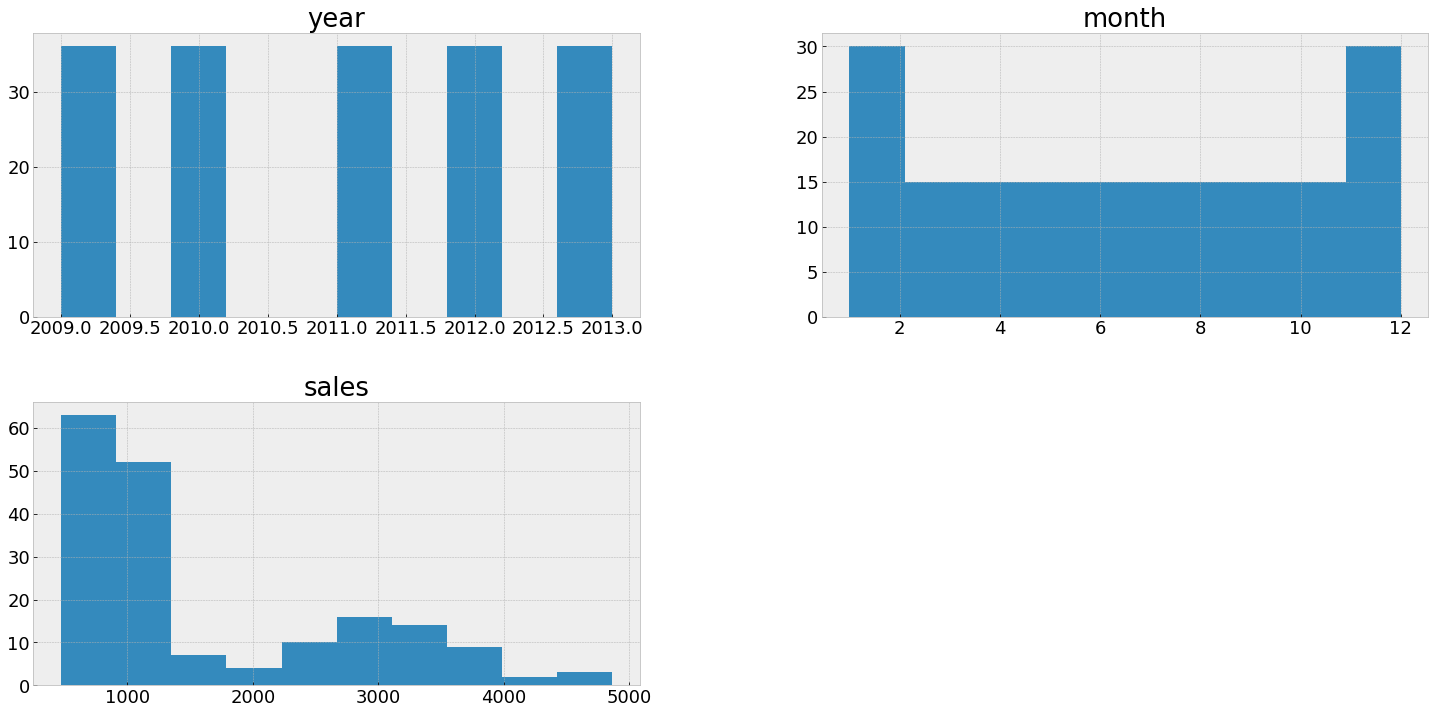

In [107]:
df_train.hist();

<AxesSubplot:>

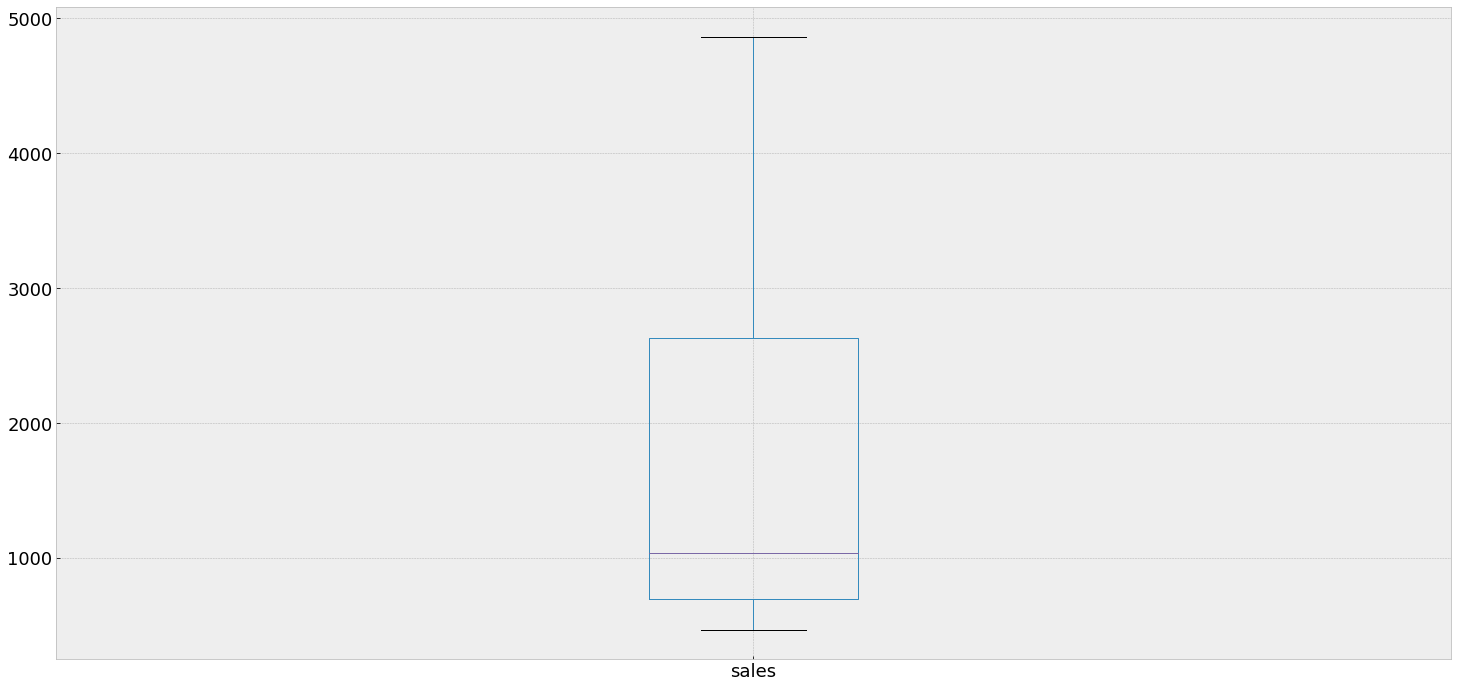

In [108]:
df_train['sales'].plot(kind='box')

#### 1.2.2 - Categorical

In [109]:
categorical = df_train.select_dtypes(include='object')

In [110]:
categorical.value_counts()

product_category
WomenClothing       60
OtherClothing       60
MenClothing         60
dtype: int64

## 2.0 - Feature Engineering

### 2.1 New Features

## 3.0 - Variables Filters

### 3.1 Lines Filters

### 3.2 Columns Filters

## 4.0 - Exploratory Data Analysis

### 4.1 Mind Map

### 4.2 Hypotheses List

### 4.3 Univariate Analysis

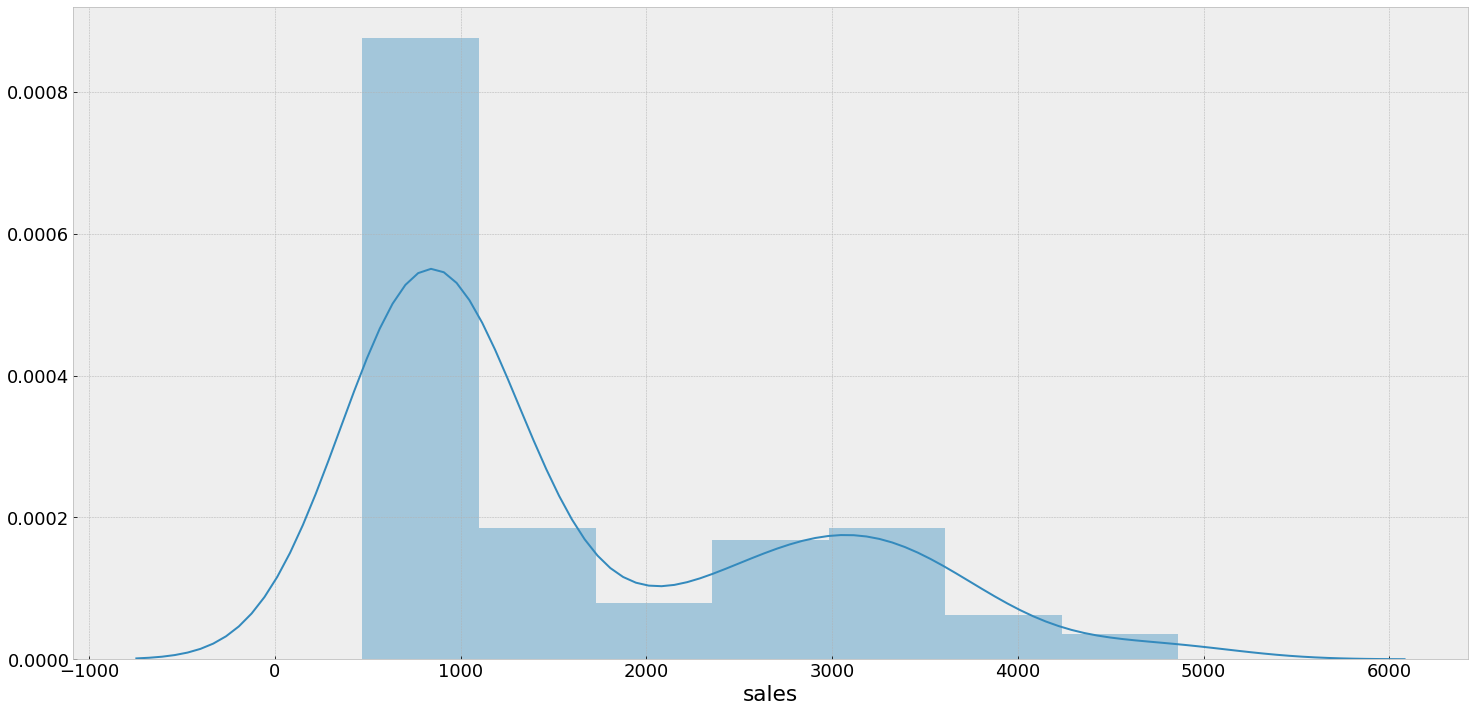

In [111]:
sns.distplot(df_train['sales']);

### 4.4 Bivariate Analysis

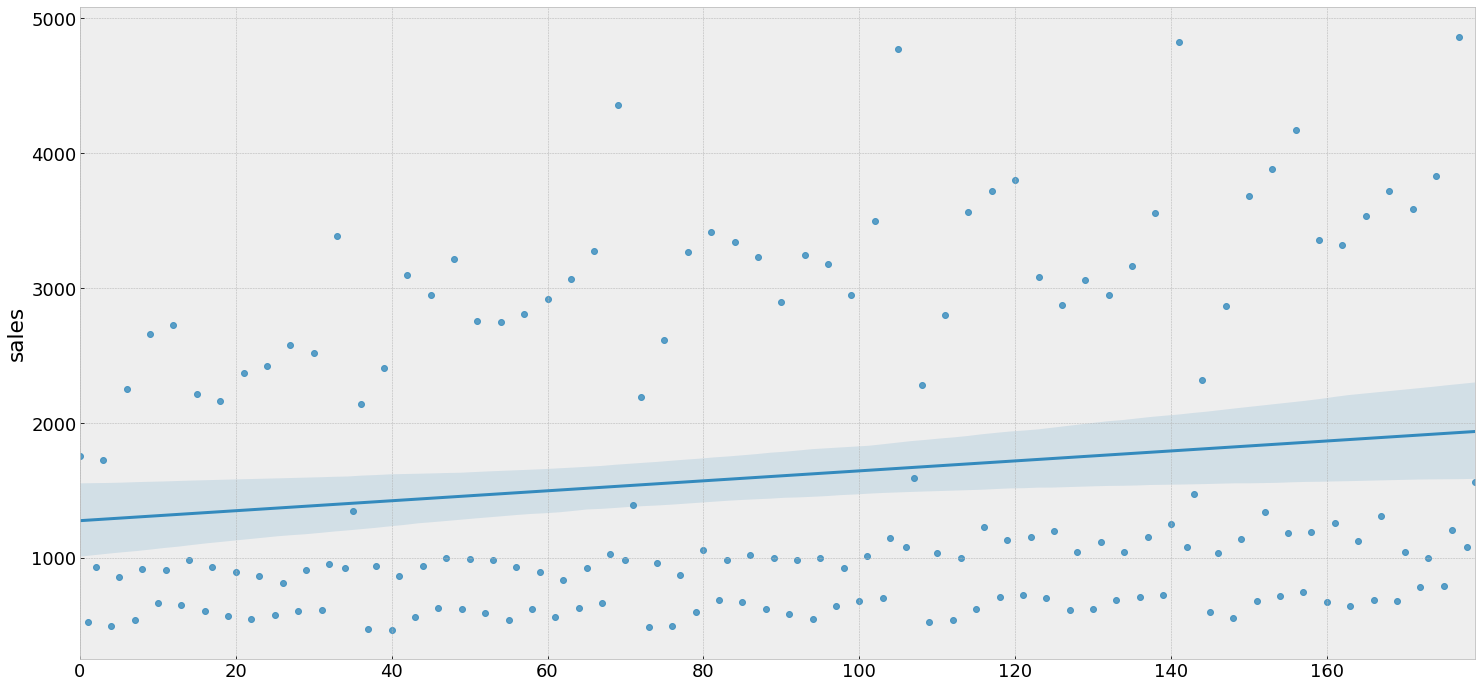

In [112]:
sns.regplot(x=df_train.index, y='sales', data=df_train);

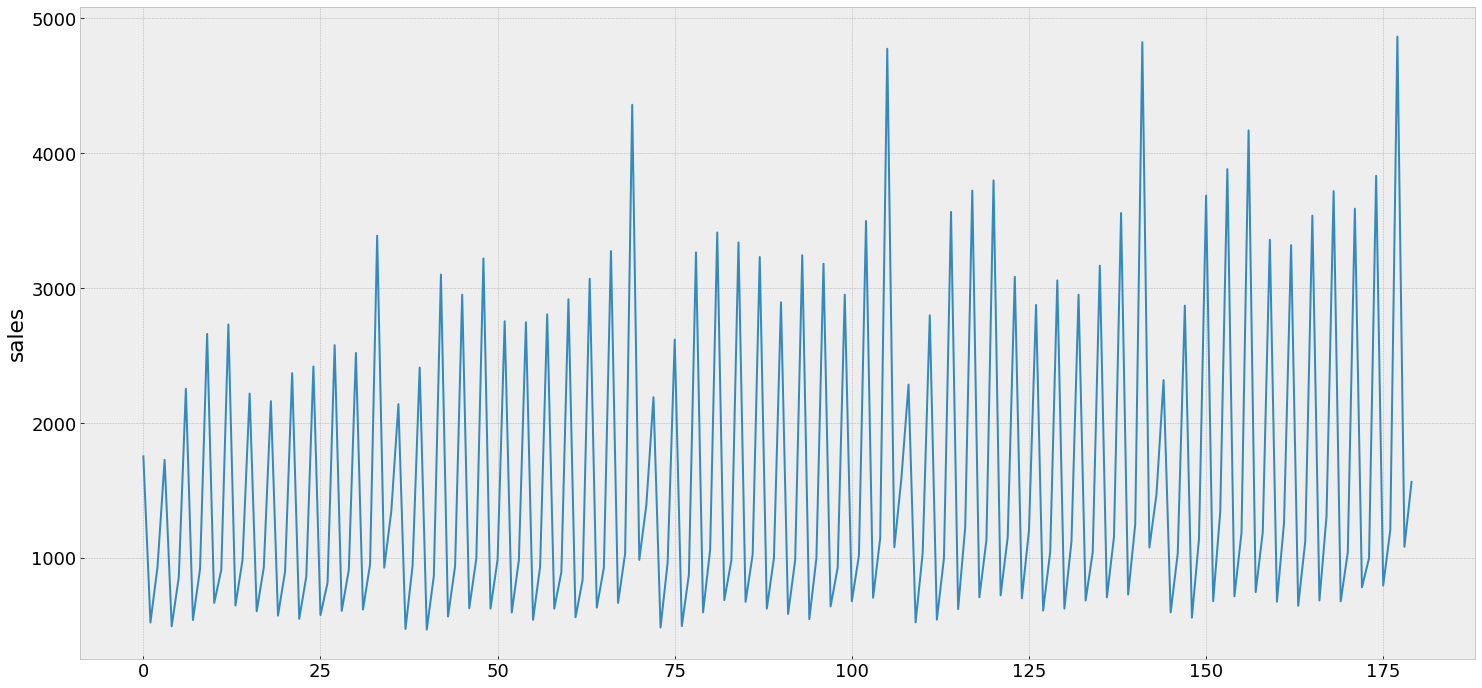

In [113]:
sns.lineplot(x=df_train.index, y='sales', data=df_train);

### 4.4 Multivariate Analysis

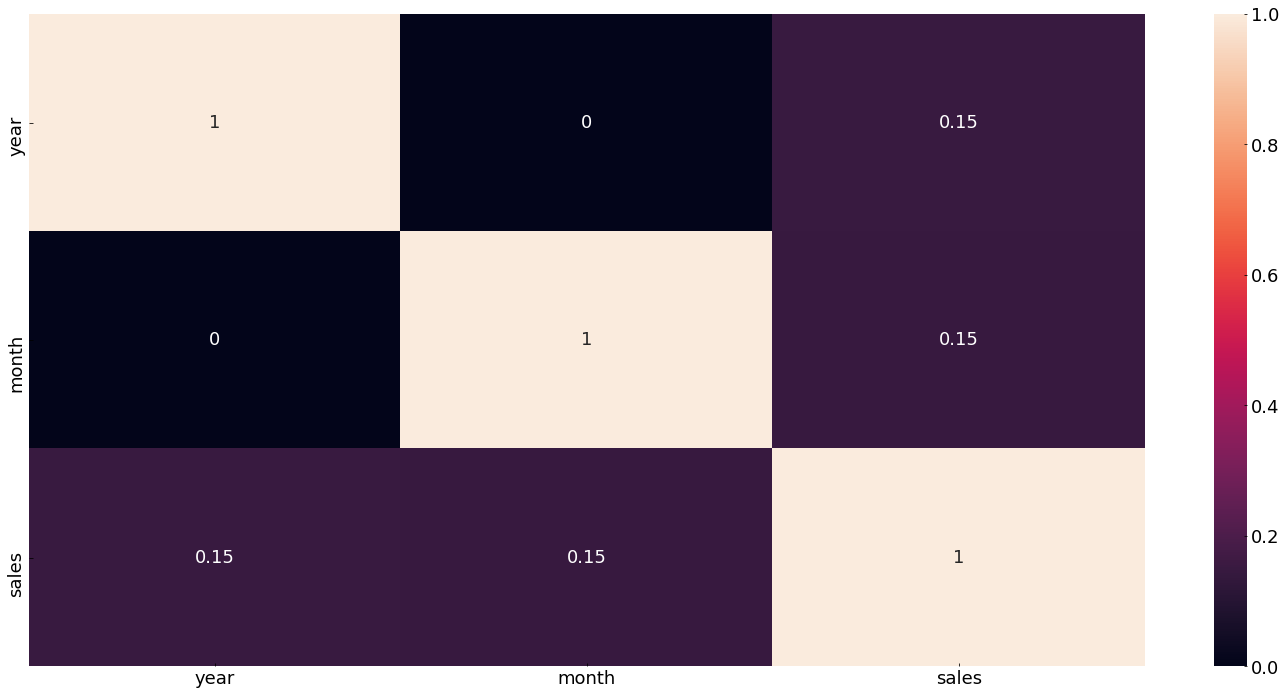

In [114]:
sns.heatmap(df_train.corr(), annot=True);

## 5.0 - Data Preparation

### 5.1 Normalization

### 5.2 Rescaling

In [115]:
mms = MinMaxScaler()

In [116]:
# Train
df_train['year'] = mms.fit_transform(df_train[['year']].values)


# Test
df_test['year'] = mms.fit_transform(df_test[['year']].values)

### 5.3 Transformation

#### 5.3.1 Encoding

In [117]:
le = LabelEncoder()

# Train
df_train['product_category'] = le.fit_transform(df_train['product_category'].values)

# Test
df_test['product_category'] = le.fit_transform(df_test['product_category'].values)

#### 5.3.2 Response Transformation

In [118]:
df_train['sales'] = log1p(df_train['sales'])

#### 5.3.3 Nature Transformation

In [119]:
# Train
df_train['month_sin'] = df_train['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df_train['month_cos'] = df_train['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# Test
df_test['month_sin'] = df_test['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df_test['month_cos'] = df_test['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

## 6.0 - Feature Selection

### 6.1 Split Train and Test

In [120]:
# Train
df_train = df_train.drop(['month'], axis=1)
Xtrain = df_train[df_train.index < 159].drop('sales', axis=1).copy()
ytrain = df_train['sales'][df_train.index < 159]
Xvalid = df_train[df_train.index >= 159].drop('sales', axis=1).copy()
yvalid = df_train['sales'][df_train.index >= 159]

Xtrain.shape, ytrain.shape, Xvalid.shape, yvalid.shape

((159, 4), (159,), (21, 4), (21,))

In [121]:
# Test
df_test = df_test.drop(['month'], axis=1)
Xtest = df_test.copy()

### 6.2 Boruta

### 6.3 Manual Boruta

## 7.0 - Machine Learning Modelling

### 7.1 - Baseline Model

In [122]:
# Create ARIMA

### 7.2 - Random Forest Regressor

In [123]:
# Model Training
mdl = RandomForestRegressor(n_estimators=100, random_state=42).fit(Xtrain, ytrain)

# Prediction
yhat = mdl.predict(Xvalid)

# Metrics
result = mdl_error(np.expm1(yvalid), np.expm1(yhat))
result

,mae,mape,rmse
0,125.734447,0.063389,183.268717


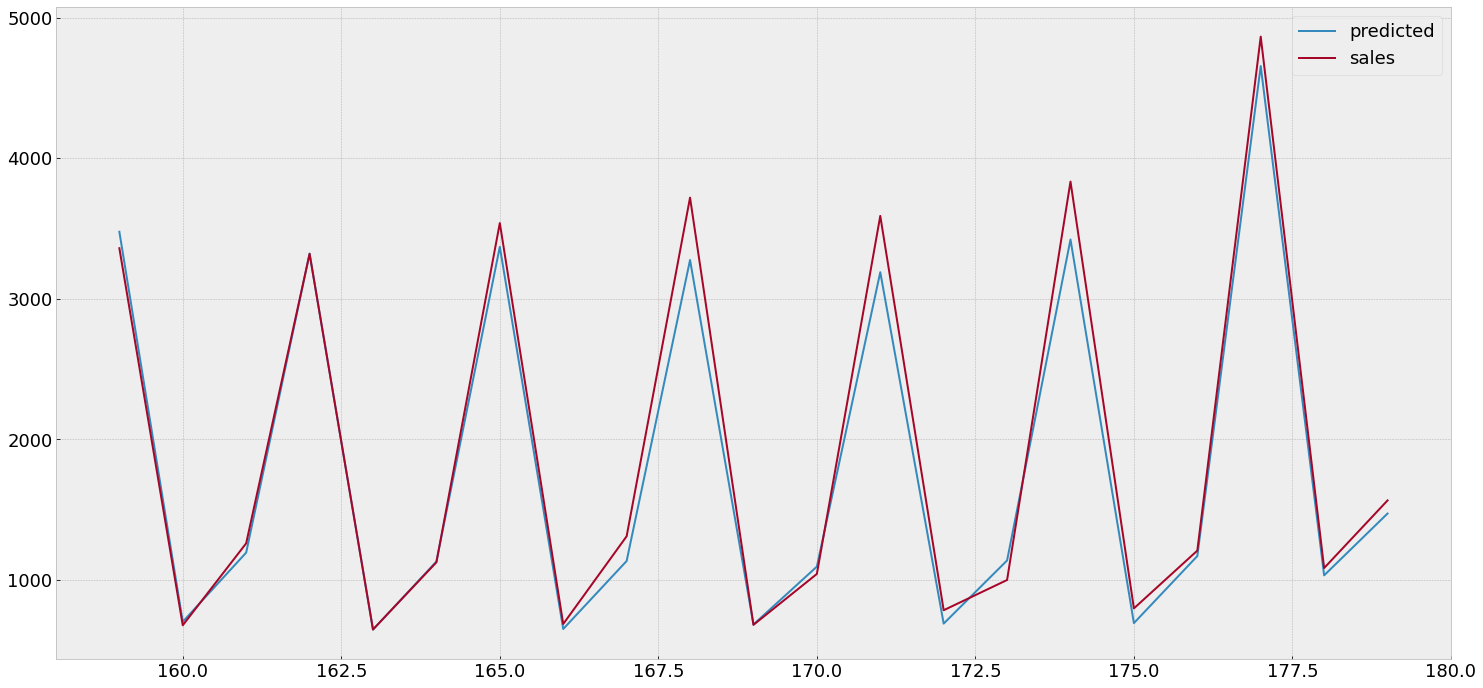

In [124]:
# Prediciont vs Real Sales
yhat_vs_yvalid = Xvalid.copy()
yhat_vs_yvalid['sales'] = np.expm1(yvalid)
yhat_vs_yvalid['predicted'] = np.expm1(yhat)

# Visualization
yhat_vs_yvalid[['predicted', 'sales']].plot();

### 7.3 - Model 02

## 8.0 - Hyperparameters

### 8.1 - Random Search

### 8.2 - Final Model

In [128]:
# Prediction From Test
yhat = mdl.predict(Xtest)

In [169]:
# Loading original test data
sub = pd.read_csv('datasets/submission.csv')

# Export csv to submit to kaggle
submission = pd.DataFrame()
submission['Year'] = range(1, 37)
submission['Sales(In ThousandDollars)'] = np.expm1(yhat)

submission.to_csv('submission.csv', index=False)